# Data Exploration for Trace Clustering

# Introduction
In this notebook, we will explore and visualize real event logs. 
We will load, decompress, and parse the logs, followed by data exploration and visualization.


In [76]:
# Loading the Event Logs
import os
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def load_event_log(path):
    return pm4py.read_xes(path)

event_log_paths = [
    '../shared/example_files/DomesticDeclarations.xes'
]

# Load event logs
logs = [load_event_log(path) for path in event_log_paths]

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

# Parsing the Event Logs
In this section, we will parse the event logs using the pm4py library.

In [77]:
# Converting logs to DataFrames for easier manipulation

def convert_log_to_dataframe(log):
    return pm4py.convert_to_dataframe(log)

dataframes = [convert_log_to_dataframe(log) for log in logs]

# Data Exploration
We will explore the event logs to understand the structure and content of the data.

In [78]:
# exploration on the first log
df = dataframes[0]

# Event Count
total_events = df.shape[0]
print(f"Total number of events: {total_events}")

# Unique Activities
unique_activities = df['concept:name'].nunique()
print(f"Number of unique activities: {unique_activities}")

# Timeframe
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
timeframe_start = df['time:timestamp'].min()
timeframe_end = df['time:timestamp'].max()
print(f"Timeframe: {timeframe_start} to {timeframe_end}")

# Event Log Summary Statistics
num_cases = df['case:concept:name'].nunique()
avg_events_per_case = df.groupby('case:concept:name').size().mean()

print(f"Number of cases: {num_cases}")
print(f"Average number of events per case: {avg_events_per_case:.2f}")

# Count of Unfinished Traces
unfinished_traces = df.groupby('case:concept:name')['concept:name'].apply(
    lambda x: not x.isin(['Payment Handled', 'Declaration REJECTED by EMPLOYEE']).any()
).reset_index(drop=True)
num_unfinished_traces = unfinished_traces.sum()
print(f"Number of unfinished traces: {num_unfinished_traces}")

# Count of Reworked Traces
reworked_traces = df.groupby('case:concept:name')['concept:name'].apply(
    lambda x: x.duplicated().any()
).reset_index(drop=True)
num_reworked_traces = reworked_traces.sum()
print(f"Number of reworked traces: {num_reworked_traces}")



Total number of events: 56437
Number of unique activities: 17
Timeframe: 2017-01-09 09:49:50+00:00 to 2019-06-17 17:30:58+00:00
Number of cases: 10500
Average number of events per case: 5.37
Number of unfinished traces: 171
Number of reworked traces: 1019


# Visualization
We will create visualizations to better understand the distribution and trends in the event logs.

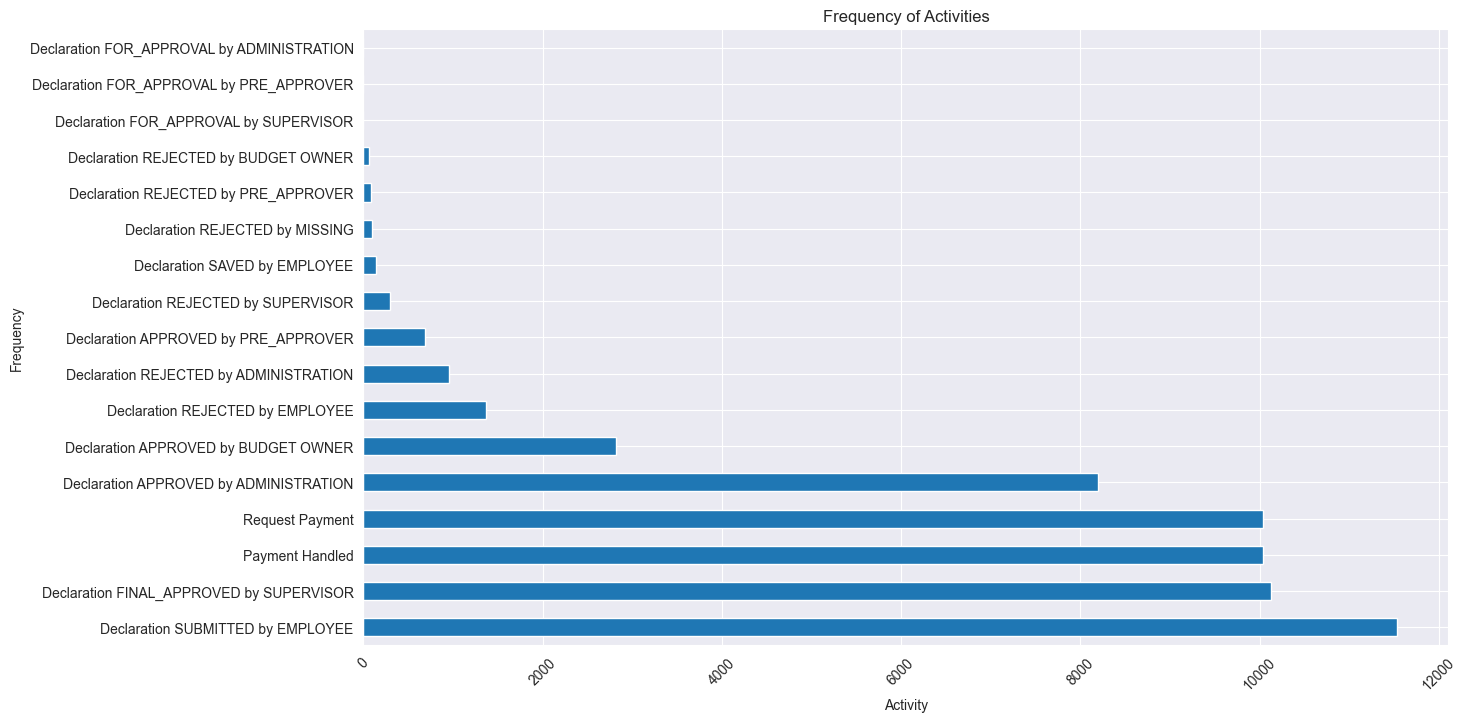

In [79]:
# Bar Chart for Activity Frequency
activity_counts = df['concept:name'].value_counts()
plt.figure(figsize=(14, 8))
activity_counts.plot(kind='barh')
plt.title('Frequency of Activities')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Additional Analyses and Visualizations
To provide deeper insights into the event logs, we will perform additional analyses and visualizations including activity duration analysis, case duration analysis, event frequency over time, activity transition analysis, and event log summary statistics.

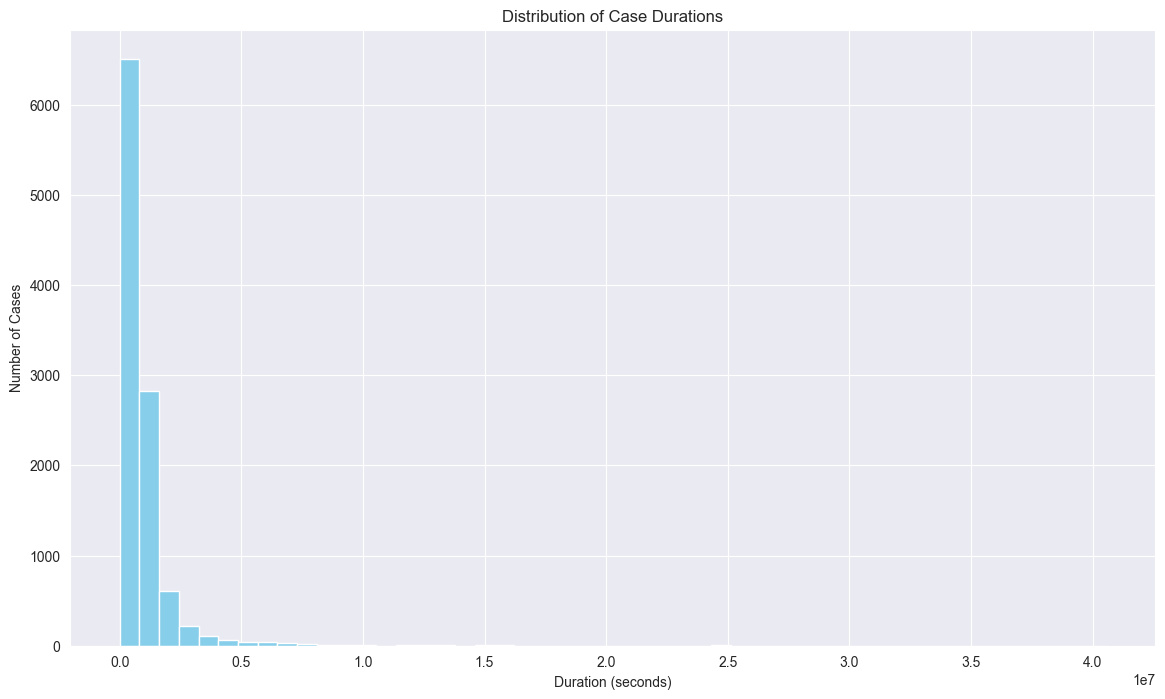

In [80]:
# Case Duration Analysis
case_duration = df.groupby('case:concept:name')['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds())

plt.figure(figsize=(14, 8))
plt.hist(case_duration, bins=50, color='skyblue')
plt.title('Distribution of Case Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Cases')
plt.show()

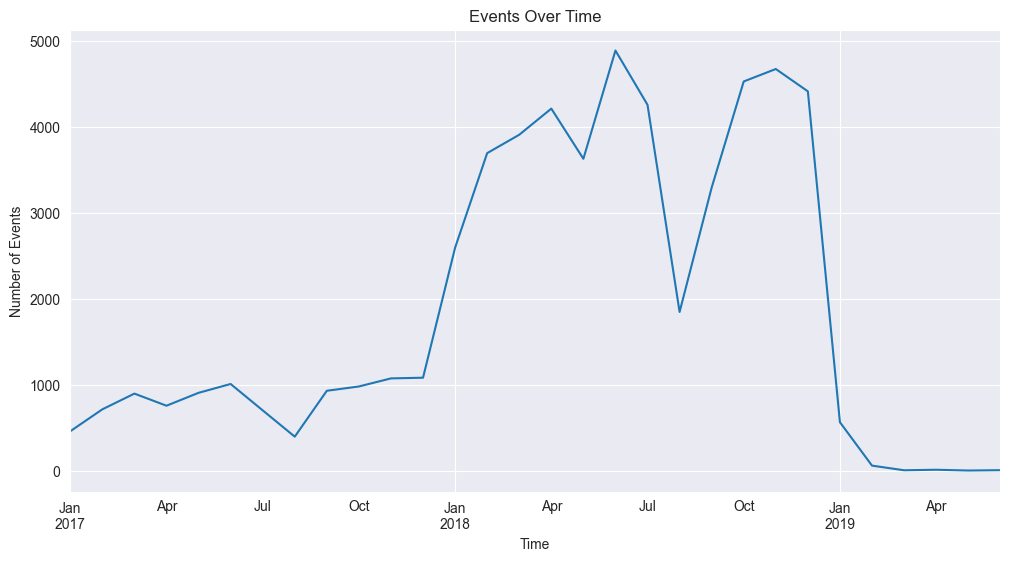

In [81]:
# Event Frequency Over Time
events_over_time = df.resample('ME', on='time:timestamp').size()

plt.figure(figsize=(12, 6))
events_over_time.plot(kind='line')
plt.title('Events Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.show()

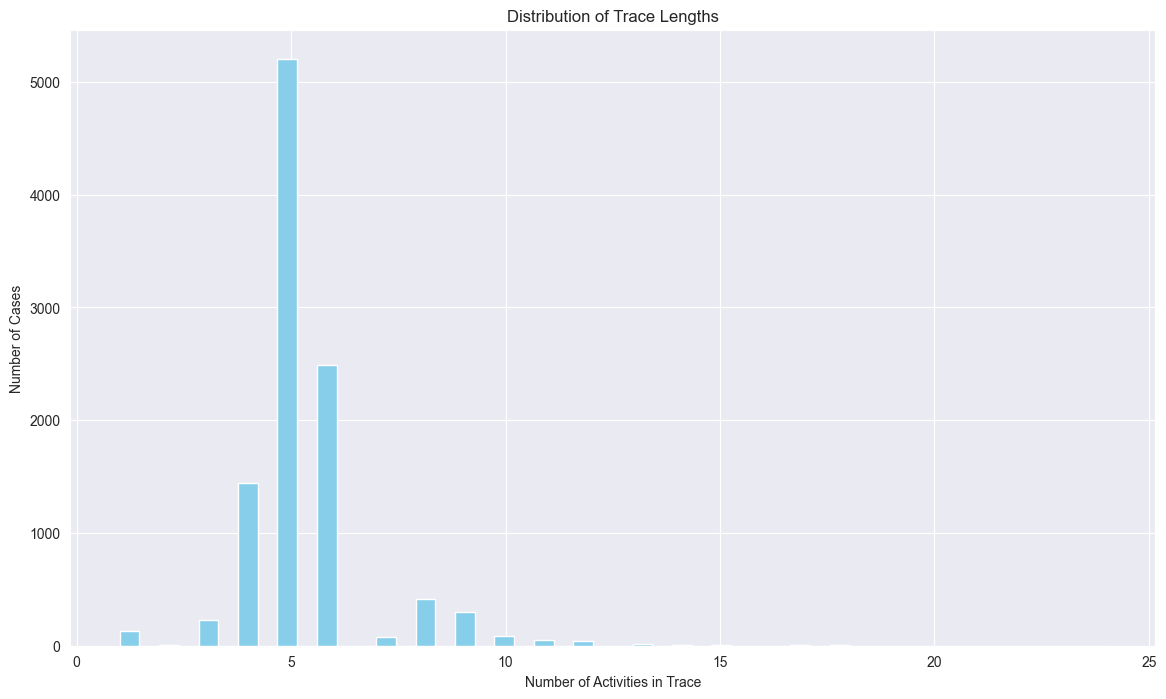

In [82]:
# Trace Length Distribution
trace_lengths = df.groupby('case:concept:name').size()

plt.figure(figsize=(14, 8))
plt.hist(trace_lengths, bins=50, color='skyblue')
plt.title('Distribution of Trace Lengths')
plt.xlabel('Number of Activities in Trace')
plt.ylabel('Number of Cases')
plt.show()

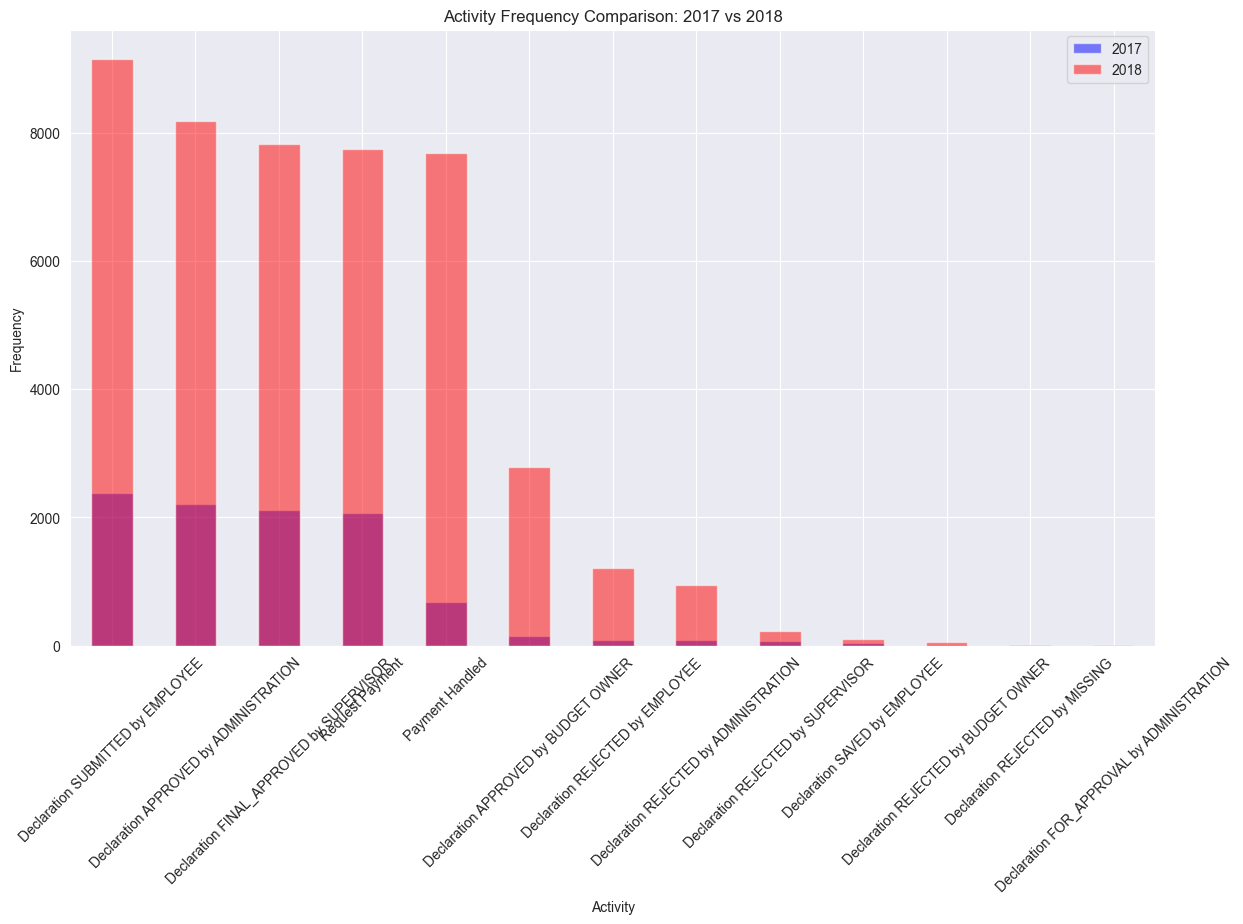

In [83]:
# Comparison of 2017 vs 2018
df['year'] = df['time:timestamp'].dt.year
activity_counts_2017 = df[df['year'] == 2017]['concept:name'].value_counts()
activity_counts_2018 = df[df['year'] == 2018]['concept:name'].value_counts()

plt.figure(figsize=(14, 8))
activity_counts_2017.plot(kind='bar', alpha=0.5, label='2017', color='blue')
activity_counts_2018.plot(kind='bar', alpha=0.5, label='2018', color='red')
plt.title('Activity Frequency Comparison: 2017 vs 2018')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(rotation=45)
plt.show()

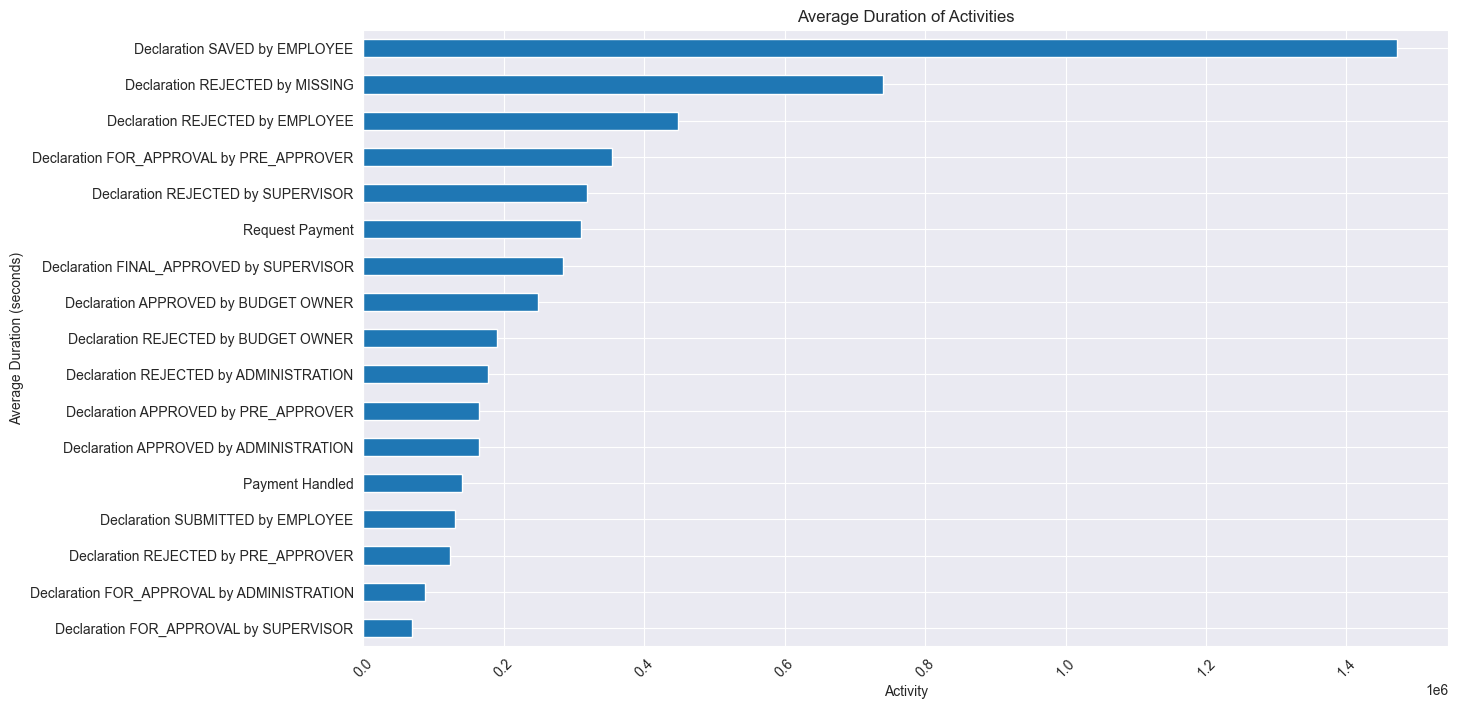

In [84]:
# Activity Duration Analysis
df['end_timestamp'] = df.groupby('case:concept:name')['time:timestamp'].shift(-1)
df['duration'] = (df['end_timestamp'] - df['time:timestamp']).dt.total_seconds()

df.dropna(subset=['duration'], inplace=True)
activity_duration = df.groupby('concept:name')['duration'].mean().sort_values()

plt.figure(figsize=(14, 8))
activity_duration.plot(kind='barh')
plt.title('Average Duration of Activities')
plt.xlabel('Activity')
plt.ylabel('Average Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

# Footprint Matrix
We will now generate and visualize the footprint matrix for the event log to understand the behavioral profiles.


/var/folders/sb/h3gzchyd3m31hqv8rp5kbrzr0000gn/T/ipykernel_99583/1564277920.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numerical_matrix = numerical_matrix.replace({'→': 1, '←': 1, '||': 0.5, '#': 0.2, '': 0}).astype(float)


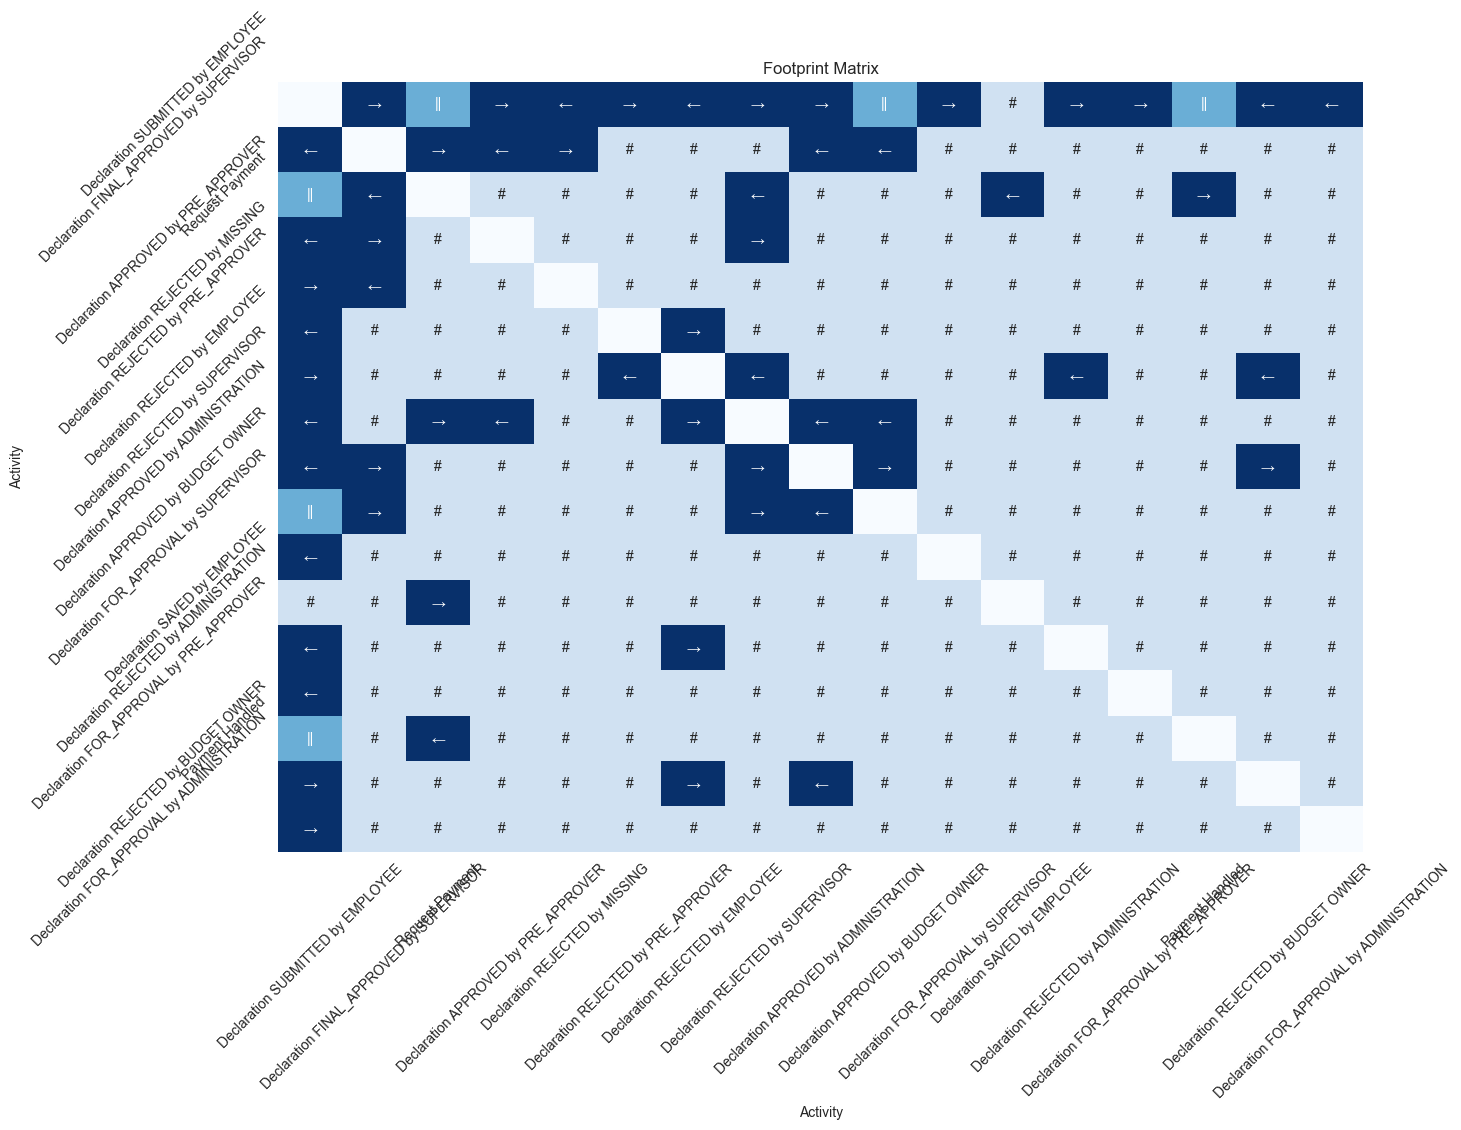

In [85]:
# Generate the Footprint Matrix
activities = df['concept:name'].unique()
footprint_matrix = pd.DataFrame(index=activities, columns=activities, data='')

for case_id, group in df.groupby('case:concept:name'):
    activities_in_case = group.sort_values('time:timestamp')['concept:name'].values
    for i in range(len(activities_in_case) - 1):
        a1 = activities_in_case[i]
        a2 = activities_in_case[i + 1]
        footprint_matrix.at[a1, a2] = '→'  # Directly follows
        footprint_matrix.at[a2, a1] = '←'  # Inverse relationship

# Calculate parallel and no-follow relationships
for a1 in activities:
    for a2 in activities:
        if a1 != a2:
            if footprint_matrix.at[a1, a2] == '' and footprint_matrix.at[a2, a1] == '':
                if df[(df['concept:name'] == a1) & (df['concept:name'].shift(-1) == a2)].empty and \
                   df[(df['concept:name'] == a2) & (df['concept:name'].shift(-1) == a1)].empty:
                    footprint_matrix.at[a1, a2] = '#'
                    footprint_matrix.at[a2, a1] = '#'
                else:
                    footprint_matrix.at[a1, a2] = '||'
                    footprint_matrix.at[a2, a1] = '||'

# Create a numerical matrix for the heatmap
numerical_matrix = footprint_matrix.copy()
numerical_matrix = numerical_matrix.replace({'→': 1, '←': 1, '||': 0.5, '#': 0.2, '': 0}).astype(float)

# Visualize the Footprint Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(numerical_matrix, annot=footprint_matrix, fmt='', cmap='Blues', cbar=False)
plt.title('Footprint Matrix')
plt.xlabel('Activity')
plt.ylabel('Activity')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


# Exploration and Visualization for Additional Event Logs
We will now explore and visualize the additional event logs in our dataset.

In [86]:
# Exploration and Visualization for Additional Event Logs
for i, df in enumerate(dataframes[1:], start=2):
    print(f"\nExploration and visualization for event log {i}")
    
    # Event Count
    total_events = df.shape[0]
    print(f"Total number of events: {total_events}")

    # Unique Activities
    unique_activities = df['concept:name'].nunique()
    print(f"Number of unique activities: {unique_activities}")

    # Timeframe
    df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
    timeframe_start = df['time:timestamp'].min()
    timeframe_end = df['time:timestamp'].max()
    print(f"Timeframe: {timeframe_start} to {timeframe_end}")
    
    # Event Log Summary Statistics
    num_cases = df['case:concept:name'].nunique()
    avg_events_per_case = df.groupby('case:concept:name').size().mean()

    print(f"Number of cases: {num_cases}")
    print(f"Average number of events per case: {avg_events_per_case:.2f}")